<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Dual_Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR", "Dual Memory ICMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
# Parameters
data_path = "data/LohnasKahana2014.csv"
trial_query = "subject > -1"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_1_0_0", "ICMR_1_0_1", "ICMR_1_1_0", "ICMR_1_1_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]
section_tag = "LohnasKahana2014"


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function lohnas_objective_function.<locals>.objective_function at 0x2abde44db4c0>


4171.165955180705
11798.446530505571


<function lohnas_objective_function.<locals>.objective_function at 0x2abde6205dc0>


4171.165955180705
11798.446530505571
<function lohnas_objective_function.<locals>.objective_function at 0x2abde5da3550>


4171.165955180705
11798.446530505571
<function lohnas_objective_function.<locals>.objective_function at 0x2abde5d485e0>


4171.9931738075275
11798.446530505571
<function lohnas_objective_function.<locals>.objective_function at 0x2abde62e0c10>


4171.9931738075275
11798.446530505571
dependencies and parameters validated


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag LohnasKahana2014 already exist
ICMR_1_0_0, Subject 1


1897.6369826700547
ICMR_1_0_0, Subject 2


1405.256739240674
ICMR_1_0_0, Subject 3


2154.0521848881795
ICMR_1_0_0, Subject 4


1079.9960046464555
ICMR_1_0_0, Subject 5


2045.046301569743
ICMR_1_0_0, Subject 6


2074.227311556931
ICMR_1_0_0, Subject 7


999.0550825212738
ICMR_1_0_0, Subject 8


1984.3464198529332
ICMR_1_0_0, Subject 10


1528.6323690961813
ICMR_1_0_0, Subject 11


2475.1358288073347
ICMR_1_0_0, Subject 12


1903.7002061017588
ICMR_1_0_0, Subject 13


2146.395360521942
ICMR_1_0_0, Subject 14


2854.6732708845457
ICMR_1_0_0, Subject 15


1607.4206209059898
ICMR_1_0_0, Subject 16


1926.9200630360453
ICMR_1_0_0, Subject 17


1707.5890590683118
ICMR_1_0_0, Subject 18


1719.3815073557528
ICMR_1_0_0, Subject 19


1709.1138744429693
ICMR_1_0_0, Subject 20


1292.1089847502976
ICMR_1_0_0, Subject 21


2049.4514562080117
ICMR_1_0_0, Subject 22


1176.4639322092987
ICMR_1_0_0, Subject 23


1375.126260023182
ICMR_1_0_0, Subject 24


1450.9897348057843
ICMR_1_0_0, Subject 25


1805.9110492973439
ICMR_1_0_0, Subject 27


1084.5108488298745
ICMR_1_0_0, Subject 28


1085.214199112733
ICMR_1_0_0, Subject 29


1624.7056459419696
ICMR_1_0_0, Subject 30


1242.7211133622513
ICMR_1_0_0, Subject 31


1373.1428123830206
ICMR_1_0_0, Subject 32


2026.0041058683237
ICMR_1_0_0, Subject 33


1602.9441414664523
ICMR_1_0_0, Subject 34


1720.4005953789997
ICMR_1_0_0, Subject 35


1907.3736032347658
ICMR_1_0_0, Subject 36


1593.7247584545323
ICMR_1_0_0, Subject 37


852.9333771590373
ICMR_1_0_1, Subject 1


1896.7719720557868
ICMR_1_0_1, Subject 2


1405.634751691331
ICMR_1_0_1, Subject 3


2132.2244305357044
ICMR_1_0_1, Subject 4


1083.785176636576
ICMR_1_0_1, Subject 5


2045.0479395238256
ICMR_1_0_1, Subject 6


2078.0815181051867
ICMR_1_0_1, Subject 7


997.4908827637714
ICMR_1_0_1, Subject 8


1977.8903439640474
ICMR_1_0_1, Subject 10


1528.0320670989117
ICMR_1_0_1, Subject 11


2548.8190516464383
ICMR_1_0_1, Subject 12


1906.2109405089934
ICMR_1_0_1, Subject 13


2146.181043832727
ICMR_1_0_1, Subject 14


2726.2683971581946
ICMR_1_0_1, Subject 15


1606.9871766183835
ICMR_1_0_1, Subject 16


1955.4746407683347
ICMR_1_0_1, Subject 17


1728.1848119772917
ICMR_1_0_1, Subject 18


1719.318408091732
ICMR_1_0_1, Subject 19


1716.2188241472152
ICMR_1_0_1, Subject 20


1300.970766851416
ICMR_1_0_1, Subject 21


2050.5777980180433
ICMR_1_0_1, Subject 22


1207.9487477040448
ICMR_1_0_1, Subject 23


1370.3515163046902
ICMR_1_0_1, Subject 24


1434.1561222708642
ICMR_1_0_1, Subject 25


1824.5482446863657
ICMR_1_0_1, Subject 27


1084.1861210390844
ICMR_1_0_1, Subject 28


1084.554043629781
ICMR_1_0_1, Subject 29


1615.492882041103
ICMR_1_0_1, Subject 30


1242.1423494783212
ICMR_1_0_1, Subject 31


1373.1793091004738
ICMR_1_0_1, Subject 32


2026.0049489847358
ICMR_1_0_1, Subject 33


1646.5504668481033
ICMR_1_0_1, Subject 34


1720.1983870219904
ICMR_1_0_1, Subject 35


1904.102468411948
ICMR_1_0_1, Subject 36


1595.2978977652344
ICMR_1_0_1, Subject 37


946.2119154348183
ICMR_1_1_0, Subject 1


1866.9636784490008
ICMR_1_1_0, Subject 2


1405.1696574231028
ICMR_1_1_0, Subject 3


2154.029842324344
ICMR_1_1_0, Subject 4


1083.5675816159433
ICMR_1_1_0, Subject 5


2038.038784123712
ICMR_1_1_0, Subject 6


2072.3007925525176
ICMR_1_1_0, Subject 7


1000.0270678556101
ICMR_1_1_0, Subject 8


2048.002035764611
ICMR_1_1_0, Subject 10


1527.4678533653955
ICMR_1_1_0, Subject 11


2474.196303811381
ICMR_1_1_0, Subject 12


1870.5579162759611
ICMR_1_1_0, Subject 13


2162.5669469346813
ICMR_1_1_0, Subject 14


2746.7464643120347
ICMR_1_1_0, Subject 15


1605.051267588296
ICMR_1_1_0, Subject 16


1954.325071912817
ICMR_1_1_0, Subject 17


1725.558923437359
ICMR_1_1_0, Subject 18


1708.181860326062
ICMR_1_1_0, Subject 19


1708.445154062407
ICMR_1_1_0, Subject 20


1296.2255483304848
ICMR_1_1_0, Subject 21


2040.6770349485114
ICMR_1_1_0, Subject 22


1178.2790290519497
ICMR_1_1_0, Subject 23


1369.9076053897284
ICMR_1_1_0, Subject 24


1433.23438146519
ICMR_1_1_0, Subject 25


1807.181173595654
ICMR_1_1_0, Subject 27


1084.41341473191
ICMR_1_1_0, Subject 28


1084.4351600591417
ICMR_1_1_0, Subject 29


1632.8174991884832
ICMR_1_1_0, Subject 30


1242.6965887034667
ICMR_1_1_0, Subject 31


1373.3596311246856
ICMR_1_1_0, Subject 32


2023.331117984355
ICMR_1_1_0, Subject 33


1569.7112189954546
ICMR_1_1_0, Subject 34


1720.3857758244437
ICMR_1_1_0, Subject 35


1902.8017786501462
ICMR_1_1_0, Subject 36


1595.4169613844253
ICMR_1_1_0, Subject 37


847.1170618573085
ICMR_1_1_1, Subject 1


1886.9534185439031
ICMR_1_1_1, Subject 2


1411.0317327115558
ICMR_1_1_1, Subject 3


2153.824011132719
ICMR_1_1_1, Subject 4


1082.4551021703671
ICMR_1_1_1, Subject 5


2038.0439224582701
ICMR_1_1_1, Subject 6


2079.817488492585
ICMR_1_1_1, Subject 7


999.1250234676635
ICMR_1_1_1, Subject 8


1985.680279846231
ICMR_1_1_1, Subject 10


1519.1103038082101
ICMR_1_1_1, Subject 11


2494.5259582636336
ICMR_1_1_1, Subject 12


1897.5285310133816
ICMR_1_1_1, Subject 13


2168.556895991063
ICMR_1_1_1, Subject 14


2799.522693415988
ICMR_1_1_1, Subject 15


1609.5702272023468
ICMR_1_1_1, Subject 16


1958.2101723707608
ICMR_1_1_1, Subject 17


1711.2626446492661
ICMR_1_1_1, Subject 18


1710.2976154835721
ICMR_1_1_1, Subject 19


1724.3001325882224
ICMR_1_1_1, Subject 20


1291.553576102097
ICMR_1_1_1, Subject 21


2052.9903705173824
ICMR_1_1_1, Subject 22


1173.5968942362126
ICMR_1_1_1, Subject 23


1389.6005810722213
ICMR_1_1_1, Subject 24


1435.2410781136246
ICMR_1_1_1, Subject 25


1829.301394556375
ICMR_1_1_1, Subject 27


1092.2596643739892
ICMR_1_1_1, Subject 28


1091.2378092360848
ICMR_1_1_1, Subject 29


1623.0203425463274
ICMR_1_1_1, Subject 30


1274.426136234685
ICMR_1_1_1, Subject 31


1373.345847558437
ICMR_1_1_1, Subject 32


2019.1020445450006
ICMR_1_1_1, Subject 33


1571.0470864547333
ICMR_1_1_1, Subject 34


1740.0697946839925
ICMR_1_1_1, Subject 35


1902.50712437234
ICMR_1_1_1, Subject 36


1594.3743109564837
ICMR_1_1_1, Subject 37


847.358524458423


Text(-1.9305555555555483, 0.5, 'Individual Log-Likelihood')

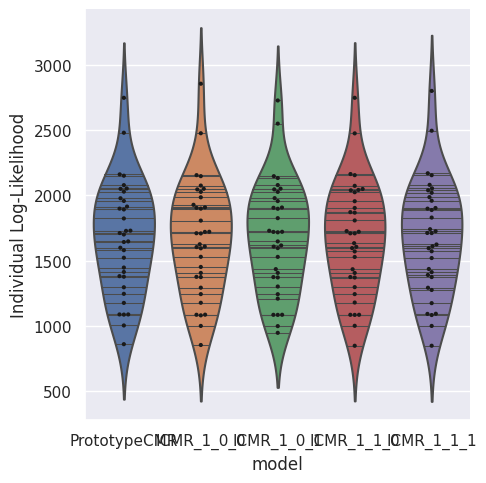

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learn_first
0,1,48,1891.357899,PrototypeCMR,0.798123,0.977743,0.931718,0.063036,1.000000e+00,0.208659,0.553725,44.032412,0.001528,0.256302,1.883059,4.938593e-01,NaN,NaN,NaN
1,2,48,1412.645149,PrototypeCMR,0.868753,0.024969,0.965059,0.032766,2.220446e-16,0.305002,21.719803,0.628644,0.022127,0.166547,0.890981,9.830417e-01,NaN,NaN,NaN
2,3,48,2160.209923,PrototypeCMR,0.840663,0.082266,0.946690,0.028403,1.000000e+00,0.314835,6.880786,57.452401,0.009493,0.136745,1.023366,9.264617e-01,NaN,NaN,NaN
3,4,48,1087.073304,PrototypeCMR,0.919006,0.007289,0.992128,0.002611,5.643857e-02,0.366473,100.000000,47.570112,0.055830,0.125027,0.489373,1.546793e-09,NaN,NaN,NaN
4,5,48,2049.012303,PrototypeCMR,0.646094,0.998356,0.891662,0.035200,1.000000e+00,0.258018,1.208496,49.495472,0.006254,0.192287,1.278988,9.223255e-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,33,48,1571.047086,ICMR_1_1_1,0.640144,0.276040,0.954159,0.000115,4.786446e-03,0.003429,14.190831,0.513187,0.017739,0.184233,1.000000,2.072956e-01,1.0,1.721873,True
171,34,48,1740.069795,ICMR_1_1_1,0.814856,0.061454,0.934745,0.003977,6.350707e-01,0.449714,9.530613,56.958728,0.006974,0.160237,1.000000,9.972713e-01,1.0,1.730979,True
172,35,48,1902.507124,ICMR_1_1_1,0.823533,0.001766,0.960447,0.014760,9.999529e-01,0.617423,6.018157,15.931469,0.005376,0.201000,1.000000,9.999970e-01,1.0,1.978893,True
173,36,48,1594.374311,ICMR_1_1_1,0.814399,0.989895,0.959618,0.000933,2.793050e-01,0.683224,1.002470,84.527913,0.026128,0.137219,1.000000,6.747566e-01,1.0,0.687084,True


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-LohnasKahana2014fits layout-nrow=2 layout-valign="center"}

![](results/individual_LohnasKahana2014.pdf)

|       |   ICMR_1_0_0 |   ICMR_1_0_1 |   ICMR_1_1_0 |   ICMR_1_1_1 |   PrototypeCMR |
|:------|-------------:|-------------:|-------------:|-------------:|---------------:|
| count |       35     |       35     |       35     |       35     |         35     |
| mean  |     1670.92  |     1675     |     1667.23  |     1672.31  |       1671.65  |
| std   |      436.924 |      425.443 |      430.191 |      433.932 |        428.736 |
| min   |      852.933 |      946.212 |      847.117 |      847.359 |        859.212 |
| 25%   |     1374.13  |     1371.77  |     1371.63  |     1381.47  |       1378.23  |
| 50%   |     1707.59  |     1716.22  |     1708.18  |     1710.3   |       1699.68  |
| 75%   |     1955.63  |     1966.68  |     1988.83  |     1971.95  |       1966.8   |
| max   |     2854.67  |     2726.27  |     2746.75  |     2799.52  |       2746.62  |

Distribution 

In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_1_0_0')
Ttest_relResult(statistic=0.19321019708230702, pvalue=0.8479439414984872)
Ttest_relResult(statistic=0.19321019708230702, pvalue=0.5760280292507564)
Ttest_relResult(statistic=0.19321019708230702, pvalue=0.4239719707492436)

('PrototypeCMR', 'ICMR_1_0_1')
Ttest_relResult(statistic=-0.7765388938987106, pvalue=0.4427998931422358)
Ttest_relResult(statistic=-0.7765388938987106, pvalue=0.2213999465711179)
Ttest_relResult(statistic=-0.7765388938987106, pvalue=0.7786000534288822)

('PrototypeCMR', 'ICMR_1_1_0')
Ttest_relResult(statistic=1.5914857268566458, pvalue=0.12075651810723394)
Ttest_relResult(statistic=1.5914857268566458, pvalue=0.9396217409463831)
Ttest_relResult(statistic=1.5914857268566458, pvalue=0.06037825905361697)

('PrototypeCMR', 'ICMR_1_1_1')
Ttest_relResult(statistic=-0.25671848801544167, pvalue=0.7989432387307607)
Ttest_relResult(statistic=-0.25671848801544167, pvalue=0.39947161936538034)
Ttest_relResult(statistic=-0.25671848801544167, pvalue=0.

In [9]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_1_0_0')
0.2571428571428571 0.7428571428571429
9 26

('PrototypeCMR', 'ICMR_1_0_1')
0.37142857142857144 0.6285714285714286
13 22

('PrototypeCMR', 'ICMR_1_1_0')
0.2 0.8
7 28

('PrototypeCMR', 'ICMR_1_1_1')
0.42857142857142855 0.5714285714285714
15 20

('ICMR_1_0_0', 'ICMR_1_0_1')
0.5142857142857142 0.4857142857142857
18 17

('ICMR_1_0_0', 'ICMR_1_1_0')
0.34285714285714286 0.6571428571428571
12 23

('ICMR_1_0_0', 'ICMR_1_1_1')
0.5714285714285714 0.42857142857142855
20 15

('ICMR_1_0_1', 'ICMR_1_1_0')
0.3142857142857143 0.6857142857142857
11 24

('ICMR_1_0_1', 'ICMR_1_1_1')
0.5714285714285714 0.42857142857142855
20 15

('ICMR_1_1_0', 'ICMR_1_1_1')
0.6285714285714286 0.37142857142857144
22 13



In [10]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[8.44027694e-068 8.41257885e-057 8.16165340e-119 1.00000000e+000
 6.96631957e-078]


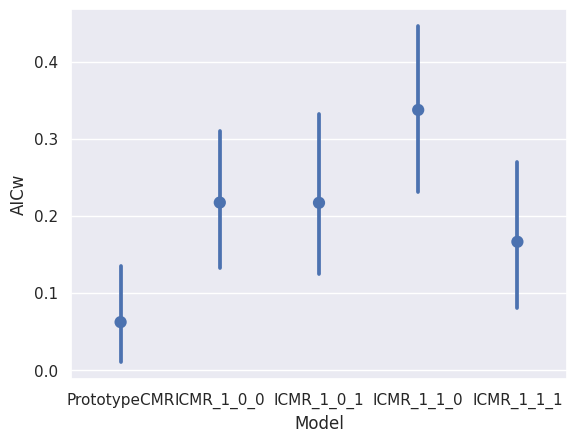

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                #model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df_from_events(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")

NameError: name 'simulate_df_from_events' is not defined